## Hansen with DDP

#### Translated from Eva Carceles-Poveda's MATLAB codes

In [1]:
# Importing packages
import numpy as np

# This is used to calculate the excution time of several loops
import time

import matplotlib.pyplot as plt
# The magic command below causes the resulting plots to be stored in the notebook document
# Only works in IPython Notebooks and not in regular Python files
%matplotlib inline

# needed for compact printing of numpy arrays
# use precision to set the number of decimal digits to display
# use suppress=True to show values in full decimals instead of using scientific notation
np.set_printoptions(suppress=True,precision=4,linewidth=np.inf)

#### The functions lgwt and acm are copied below.

In [2]:
def lgwt(N,a,b):
    """ Syntax: [x,w]=lgwt(N,a,b)
    
    This script is for computing definite integrals using Legendre-Gauss 
    Quadrature. Computes the Legendre-Gauss nodes and weights on an interval
    [a,b] with truncation order N.
    
    Suppose you have a continuous function f(x) which is defined on [a,b]
    which you can evaluate at any x in [a,b]. Simply evaluate it at all of
    the values contained in the x vector to obtain a vector f. Then compute
    the definite integral using sum(f.*w);
    
    Translated from Greg von Winckel's Matlab Script written on 02/25/2004
    """

    N = N-1
    N1 = N+1; N2 = N+2;

    xu = np.linspace(-1,1,N1)

    # Initial guess
    y=np.cos((2*np.arange(0,N+1)+1)*np.pi/(2*N+2))+(0.27/N1)*np.sin(np.pi*xu*N/N2)

    # Compute the zeros of the N+1 Legendre Polynomial
    # using the recursion relation and the Newton-Raphson method

    y0=2

    # Iterate until new points are uniformly within epsilon of old points
    while np.abs(y-y0).max() > np.finfo(float).eps:
        
        # Legendre-Gauss Vandermonde Matrix
        L=np.zeros((N1,N2))

        # Derivative of LGVM
        Lp=np.zeros((N1,N2))
        
        L[:,0]=1
        Lp[:,0]=0

        L[:,1]=y
        Lp[:,1]=1
        
         
        for k in np.arange(1,N1):
            L[:,k+1]=( (2*(k+1)-1)*y*L[:,k]-((k+1)-1)*L[:,k-1] )/(k+1)

            
        Lp=(N2)*(L[:,N1-1]-y*L[:,N2-1] )/(1-y**2)

        y0=y.copy()
        y=y0-L[:,N2-1]/Lp


    # Linear map from[-1,1] to [a,b]
    x = ((a*(1-y)+b*(1+y))/2).T

    # Compute the weights
    w = ((b-a)/((1-y**2)*Lp**2)*(N2/N1)**2).T
       
    return x, w

In [3]:
# scipy.stats.norm: a normal continuous random variable.
from scipy.stats import norm

# needed for Gauss-Lobatto only
from scipy.integrate import quad

# Adda-Cooper's method of approximating an AR(1) process with normally distributed innovation.
def acm(mu,rho,sigma,n,me=1):
    """ Syntax: [ss,tm,sd,sm,ssd,sac] = acm(mu,rho,sigma,n,me) 

    ss is state space, tm is transition matrix, sd is stationary distribution,
    sm is stationary mean, ssd is stationary standard deviation and sac is 
    stationary autocorrelation. mu is the mean of the AR process, rho is 
    the autocorrelation and sigma is the standard deviation of the innovation.
    n is the number of states and me stands for the method used in numerical integration.
    """
    
    tm = np.zeros((n,n))
    sg = sigma / (np.sqrt(1 - rho**2))     # sg is the variance of AR process
    
    # n + 1 interval nodes for defining the states, trucated at two ends.
    node = sg * norm.ppf(np.arange(0,n+1) / n + np.concatenate((np.array([np.spacing(1)]), np.zeros((1,7 - 1))[0],\
                                                                    (np.array([-np.spacing(1)]))))) + mu
    

    # lengths of n intervals.
    itv = node[1:n + 1] - node[0:n]
    

    ss = n * sg * (norm.pdf((node[0:n] - mu) / sg) - norm.pdf((node[1:n+1] - mu) / sg)) + mu
    
    # itvu is the upper bound of an interval, itvl likewise.
    f = lambda u,itvu,itvl: np.exp(-(u - mu)**2 / 2 / sg**2)*\
    (norm.cdf((itvu - mu*(1 - rho) - rho*u)/sigma) -\
     norm.cdf((itvl - mu*(1 - rho) - rho*u)/sigma)) / np.sqrt(2 * np.pi) / sg
    
    
    match me:
        case 1:
            # use Gauss-Legendre method

            # Generate 10 nodes and corresponding weights using Winckel's function lgwt.
            m = 10
            x,w = lgwt(m,-1,1)    

            start = time.perf_counter()
            for i in np.arange(0,n):
                f_i = lambda u: f(u,node[i + 1],node[i])
                tm[i,:] = 0.5 * itv * (np.matmul(w,f_i(np.matmul((x + 1)[:,np.newaxis], itv[np.newaxis,:]) / 2 \
                                                    + np.ones((m,1)) * node[0:n])))

                tm[i,:] = tm[i,:]/np.sum(tm[i,:])
                

            stop = time.perf_counter()
            print("Time of the Gauss-Legendre method is:", round(stop - start,4))

        
        case 2:
            # use recursive adaptive Gauss-Lobatto quadrature
            start = time.perf_counter()
            for i in np.arange(0,n):
                f_i = lambda u: f(u,node[i + 1],node[i])
                for j in np.arange(0,n):
                    tm[i,j] = quad(f_i,node[j],node[j + 1])[0]

                tm[i,:] = tm[i,:]/np.sum(tm[i,:])

            stop = time.perf_counter()
            print("Time of Gauss-Lobatto method is:", round(stop - start,4))

    sd = np.dot((np.concatenate((np.zeros((1,n - 1))[0],(np.array([1]))))),\
    np.linalg.inv((np.append(tm[:,0:n - 1] - np.eye(n,n - 1),np.ones((n,1)),1))))
    sd = sd / sum(sd)
    sm = np.dot(sd, ss)
    ssd = np.sqrt(np.dot((ss - sm)**2, sd.T))

    sac = (np.matmul((ss[:,np.newaxis] - sm),ss[np.newaxis,:] - sm) *\
           np.matmul(np.diag(sd),tm)).sum(axis=1).sum(axis=0) / ssd**2
        
        
    return ss,tm,sd,sm,ssd,sac

#### The Hodrick-Prescott filter function is copied below

In [4]:
def hp1(y,w):

    """ Syntax: yhp, ytr = hp1(y, w)
    
    This function computes the filtered series of y, using
    a smoothing parameter w. 
    
    The code is from I. Izvorski.
    """

    t, s = y.shape
    
    if t < s:
        y = y.T

    a = 6*w + 1
    b = -4*w
    c = w
    d = np.array([[c,b,a]])
    d = np.ones((t,1))*d
    m = np.diag(d[:,2])+np.diag(d[0:-1,1],1)+np.diag(d[0:-1,1],-1)
    m = m+np.diag(d[0:-2,0],2)+np.diag(d[0:-2,0],-2)

    m[0,0] = 1+w;       m[0,1] = -2*w;
    m[1,0] = -2*w;      m[1,1] = 5*w+1;
    m[-2,-2] = 5*w+1;   m[-2,-1] = -2*w;
    m[-1,-2] = -2*w;    m[-1,-1] = 1+w;
    
    ytr = np.matmul(np.linalg.inv(m),y)
    
    yhp = y-ytr

    return yhp, ytr

### user defined functions for solving the problem:

In [5]:
# utility function
def fu(c, h, a):
    u = (1 - a) * np.log(c) + a * np.log(1 - h) # use Cooley & Prescott (1995) specification 
    return u


# production function
def fprod(k, alpha):
    y = k**alpha
    # In this case it is ok to compute the capital component only
    # since the production function is multiplicative.
    return y

# function determine labor supply given k',k and theta
def fh(h,rik,alpha,a):
    # rik is the ratio of investment and capital (with shock)
    y = ((1 - a) * (1 - alpha) / a + 1) * h**(1 - alpha) -\
        (1 - a) * (1 - alpha) / a * h**(-alpha) - rik
    j = ((1 - a) * (1 - alpha) / a + 1) * (1 - alpha) * h**(-alpha) +\
        (1 - a) * (1 - alpha) * alpha / a * h**(-alpha - 1)
    return y, j


In [6]:
def kronv(x,y):
    # Compute kroneck product of two column vector using basic
    # built-in functions for array manipulation instead of using
    # another built-in function kron, which involves non-basic
    # functions like meshgrid.
    
    # only accepts two-dimensional numpy arrays as inputs
    
    nx = x.size
    ny = y.size

    z = np.reshape(np.matmul(y,x.T),nx * ny,order="F")
    return z

def kronm(x,y):
    # Compute kroneck product of two matrices using kronv
    # only accepts two-dimensional numpy arrays as inputs
    
    nx,kx = x.shape
    ny,ky = y.shape
    
    z = np.zeros((nx * ny,kx * ky))
    for l in np.arange(0,kx):
        for m in np.arange(0,ky):
            z[:,l * ky + m] = kronv(x[:,l][:,np.newaxis],y[:,m][:,np.newaxis])
    
    return z

In [7]:
# It's possible to use built-in function numpy.ravel_multi_index and numpy.unravel_index

def indlin(x,n):
    # Compute the linearized index of an index matrix x, presuming x is
    # generated from an array w which has one more dimension of length n.
    j,k = x.shape
    
    y = x.flatten('F') + kronv(np.ones((k,1)),n * np.arange(0,j)[:,np.newaxis]) + \
        kronv(n * j * np.arange(0,k)[:,np.newaxis],np.ones((j,1)))
    
    return y.astype(int)
              
def indmat(x,n):
    # decompose index matrix x with the range of 1 to n * k into
    # two matrices with ranges of n and k, where y corresponds to n.
    z = np.floor((x - 1)/n)
    y = x - n * z
    
    return y.astype(int), z.astype(int)


In [8]:
# Solve RBC model using dynamic programming for divisible labor supply
import scipy.optimize as opt


def dprbc(me, ir, PAR, DSS, SSK, SSS, GRIDH, TM):
    """ Syntax: [v,gk,gh,gi,gc,gy] = dprbc(me, ir, PAR, DSS, SSK, SSS, GRIDH, TM) 

    ir indicates to irreducible investment,
    with 0 to be reducible and 1 to be irreducible;
    me is the method of solving labor supply
    0 is using FOCs to determine labor given k_t and k_t+1;
    1 is dicretizing labor space
    PAR is parameter vector, DSS is deterministic steady state
    SSS is the state space of shock, TM is the transition matrix
    """
    #--------------------------------------------------------------------------
    if me not in [0,1]:
        print("dprbc input me could only be 0 or 1")
        print("defaulting to me=0")
        me=0
    
    alpha = PAR[0]
    beta = PAR[1]
    delta = PAR[2]
    a = PAR[4]

    cb = DSS[1]
    hb = DSS[2]

    sss = SSS  # column vector
    tm = TM
    ns = sss.size

    ssk = SSK
    nk = ssk.size
    gridh = GRIDH
    nh = gridh.size
    
    # initial value to be half of deterministic steady state
    vnew = 0.5 * fu(cb,hb,a) * np.ones((nk,ns)) / (1 - beta)
    vold = np.zeros((nk,ns))

    # Use focs to determine optimal labor supply for each k.T, k and theta
    iv = kronv(np.ones((nk,1)), ssk[:,np.newaxis]) - kronv((1 - delta) * ssk[:,np.newaxis], np.ones((nk,1)))
    if ir == 1:
        iv = np.maximum(iv,np.zeros((nk**2,1)))
    
    #--------------------------------------------------------------------------
    
    
    if me == 0:
        iv = kronv(np.ones((ns,1)),iv[:,np.newaxis]) # nk^2*ns by 1 array
        
        # for each combination of k.T,k and theta, solve for h
        h = np.zeros((nk**2 * ns,1))   # heuristic state space of h

        prodk = kronv(sss[:,np.newaxis],kronv(fprod(ssk,alpha),np.ones((nk,1)))[:,np.newaxis])
        rik = iv / prodk
        
        start = time.perf_counter()
        for i in np.arange(0,nk**2 * ns):
            fh_i = lambda x: fh(x,rik[i],alpha,a)[0]
            h[i] = opt.fsolve(fh_i,hb/4) # start from 0.1

        stop = time.perf_counter()
        print("Time of solving for h is:", round(stop - start,4), "seconds")
        h = np.minimum(h,1-1e-6)
        h = np.maximum(h,0)   # truncate h at 0 and 1

        # second compute consumption array

        c = prodk*np.squeeze(h)**(1 - alpha)-iv

        Ic = np.argwhere(c >= 0) # indices of infeasible consumption

        # initialize current utility array by assigning large negative value
        u = -0.5 * np.finfo(float).max * np.ones((nk**2 * ns,1))
        
        # utility level is large negative for infeasible consumption
        u[Ic] = fu(c[:,np.newaxis][Ic],h[Ic],a)
        
        u = u.reshape((nk,nk,ns),order="F") # put u into the required array form
        
        
        tol = np.linalg.norm(vnew - vold,1)
        print("norm =", tol)
        nitr = 0
        
        start = time.perf_counter()
        while tol > 1e-6:
            vold = vnew.copy()
            vful = np.matmul(vold, tm.T) # vful is in k.T by k by theta form            

            # Using the built-in numpy.kron is much faster than using the basic kronm and kronv 
            #vfuld = np.reshape(kronm(np.ones((nk,1)),vful),(nk,nk,ns), order='F')
            vful = np.reshape(np.kron(np.ones((nk,1)), vful), (nk,nk,ns), order='F') 

            vnew = np.amax(u + beta * vful, axis=0)
            
            tol = np.linalg.norm(vnew - vold,1)
            print("norm =", tol)
            nitr = nitr + 1
            

        stop = time.perf_counter()
        print("Time of while loop of computing h using FOC is:", round(stop - start,4), "seconds")   
        print('Number of iterations of the while loop:', nitr)
        
        vful = np.matmul(vnew, tm.T)
        vful = np.reshape(kronm(np.ones((nk,1)), vful), (nk,nk,ns), order='F')
        v, Igk = (u + beta * vful).max(axis=0), (u + beta * vful).argmax(axis=0) # Igk contains indices of gk
        
        gk = ssk.squeeze()[Igk]
        Iopt = np.reshape(indlin(Igk,nk),(nk,ns),order='F')

        # compute the linearized index for the optimal choice array of the
        # form k.T by k by theta
        gi = iv[Iopt]
        gh = h.squeeze()[Iopt]
        gc = c[Iopt]
        gy = gc + gi
        
        
    elif me == 1:
        # Use discret h.

        iv = kronv(kronv(np.ones((ns,1)),iv[:,np.newaxis])[:,np.newaxis],np.ones((nh,1))) # nh*nk^2*ns by 1 array
        
        c = kronv(sss[:,np.newaxis],kronv(fprod(ssk[:,np.newaxis],alpha),\
                                          kronv(np.ones((nk,1)),gridh**(1-alpha))[:,np.newaxis])[:,np.newaxis]) - iv
        
        Ic = np.argwhere(c >= 0) # indices of infeasible consumption
        
       
        h = kronv(np.ones((ns,1)),kronv(np.ones((nk,1)),kronv((np.ones((nk,1))),gridh)[:,np.newaxis])[:,np.newaxis])
        
        
        # initialize current utility array by assigning large negative value
        u = -0.5 * np.finfo(float).max * np.ones((nh * nk**2 * ns,1))
        # utility level is large negative for infeasible consumption
        u[Ic] = fu(c[:,np.newaxis][Ic],h[:,np.newaxis][Ic],a)
        u = u.reshape((nk*nh,nk,ns),order="F") # put u into the required array form
        
        
        tol = np.linalg.norm(vnew - vold,1)
        print("norm =", tol)
        nitr = 0
        
        start = time.perf_counter()
        while tol > 1e-6:
            vold = vnew.copy()
            vful = np.matmul(vold, tm.T) # vful is in k.T by k by theta form            

            # Using the built-in numpy.kron is much faster than using the basic kronm and kronv 
            #vfuld = np.reshape(kronm(np.ones((nk,1)),vful),(nk,nk,ns), order='F')
            vful = np.reshape(np.kron(np.ones((nk,1)), np.kron(vful,np.ones((nh,1)))), (nk*nh,nk,ns), order='F') 

            vnew = np.amax(u + beta * vful, axis=0)
            
            tol = np.linalg.norm(vnew - vold,1)
            print("norm =", tol)
            nitr = nitr + 1
            

        stop = time.perf_counter()
        print("Time of while loop of computing h using FOC is:", round(stop - start,4), "seconds")   
        print('Number of iterations of the while loop:', nitr)
        
        vful = np.matmul(vnew, tm.T)
        vful = np.reshape(kronm(np.ones((nk,1)), kronm(vful,np.ones((nh,1)))), (nk*nh,nk,ns), order='F') 
        
        
        v, Ighk = (u + beta * vful).max(axis=0), (u + beta * vful).argmax(axis=0) # Igk contains indices of gh and gk
        
        Igh,Igk = indmat(Ighk,nh)
        
        gk = ssk.squeeze()[Igk]
        gh = gridh.squeeze()[Igh]
        gi = gk - (1 - delta) * np.matmul(ssk, np.ones((1,ns)))
        gy = np.matmul(fprod(ssk,alpha), sss[np.newaxis,:])*gh**(1 - alpha)
        gc = gy - gi        
        
    
    return v,gk,gh,gi,gc,gy

In [9]:
# Simulate discrete finite state Markov chain
# Yan Liu, 2011.4.7

def mcsim(ss,tm,T):
    # ss is state space, tm is transition matrix, and
    # T is the number of periods to be simulated

    n = ss.size
    sd = np.matmul((np.concatenate((np.zeros((1,n - 1))[0],(np.array([1]))))),\
    np.linalg.inv((np.append(tm[0:n - 1,:].T - np.eye(n,n - 1),np.ones((n,1)),1)))) # stationary distribution
    
    sd = sd.T / np.sum(sd)
    
    Ix = np.zeros((T,1),dtype=int)    # indices of the chain
    y = np.random.random((T,1))      # random vector

    Ix[0] = np.argwhere(sd.cumsum() >= y[0])[0]

    tmcum = np.cumsum(tm,1).T    # use the transpose to accelerate computations
    for t in np.arange(1,T):
        Ix[t] = np.argwhere(tmcum[:,Ix[t - 1]] >= y[t])[0,0]

    return Ix

In [10]:
FO = 1

alpha = 0.36
beta = 0.99
gamma = 1       # log utility
delta = 0.025
a = 2/3         # correspond to A = a / (1 - a) = 2 in Hansen (1985)
PAR = np.array([alpha,beta,delta,gamma,a])  # a governs labor supply

SSS, TM = acm(0,0.95,0.00712,7,1)[0:2]
SSS = np.exp(SSS)     # acm returns the log productivity shock

# rkh is the ratio of kb and hb
rkh = (1 / alpha / beta + (delta - 1) / alpha)**(1 / (1 - alpha))

x = np.linalg.solve(np.array([[rkh, a * rkh**alpha / (1 - a) / (1 - alpha)],[rkh**(1 - alpha) - delta, -1]]),\
                   np.array([[1],[0]]))

kb = x[0]
cb = x[1]
ib = delta * kb
hb = rkh * kb
yb = cb + ib
DSS = np.array([kb,cb,hb,ib,yb])


range_k = np.array([0.894,1.115]) # around steady state
nk = 200
SSK = np.linspace(range_k[0] * kb, range_k[1] * kb, nk)


Time of the Gauss-Legendre method is: 0.0017


In [11]:
if FO == 1:
    # Hansen with Discrete Dynamic Programming: FOC for h
    nh = 100
    range_h = (range_k - 1) * 2/3 + 1
    GRIDH = np.linspace(range_h[0] * hb, min(range_h[1] * hb,1), nh)
    
    v, gk, gh, gi, gc, gy = dprbc(0,0,PAR, DSS, SSK, SSS, GRIDH, TM)
elif FO == 0:
    # Hansen with Discrete Dynamic Programming: Discretization of h
    nh = 50
    range_h = (range_k - 1) * 2/3 + 1
    GRIDH = np.linspace(range_h[0] * hb, min(range_h[1] * hb,1), nh)
    
    v, gk, gh, gi, gc, gy = dprbc(1,0,PAR, DSS, SSK, SSS, GRIDH, TM)
    

Time of solving for h is: 44.9406 seconds
norm = 3012.475974161887
norm = 44.35609302939247
norm = 19.775189282249684
norm = 27.156295640459675
norm = 29.29789778237169
norm = 30.013016937568658
norm = 30.189029695565615
norm = 30.121865859007038
norm = 29.932847790087408
norm = 29.678878645293544
norm = 29.38934377373365
norm = 29.080491924417846
norm = 28.761785687719502
norm = 28.438939956135613
norm = 28.11549916394503
norm = 27.793696018478496
norm = 27.474930014584363
norm = 27.16007995884814
norm = 26.849676321818105
norm = 26.544038216963244
norm = 26.243294197320893
norm = 25.947493453200803
norm = 25.656627998150867
norm = 25.370612331288353
norm = 25.089343593744882
norm = 24.812728865098524
norm = 24.54060415016058
norm = 24.272861888303648
norm = 24.00934096223301
norm = 23.74992299015031
norm = 23.494475372086697
norm = 23.242860524832697
norm = 22.99495059449252
norm = 22.750637319469647
norm = 22.50980414770962
norm = 22.27233867490437
norm = 22.038141555987718
norm = 2

norm = 0.7851290217583404
norm = 0.7772777315257962
norm = 0.7695049541963819
norm = 0.7618099046410975
norm = 0.7541918055819998
norm = 0.7466498875142911
norm = 0.7391833886280246
norm = 0.7317915547311706
norm = 0.7244736391738371
norm = 0.7172289027727139
norm = 0.7100566137361071
norm = 0.702956047590316
norm = 0.6959264871064939
norm = 0.688967222228051
norm = 0.6820775499987022
norm = 0.675256774492059
norm = 0.6685042067408951
norm = 0.6618191646676053
norm = 0.6552009730153685
norm = 0.6486489632799852
norm = 0.642162473642184
norm = 0.6357408489011611
norm = 0.6293834404077323
norm = 0.6230896059994322
norm = 0.616858709935471
norm = 0.6106901228324624
norm = 0.6045832216006133
norm = 0.598537389381395
norm = 0.5925520154844897
norm = 0.5866264953266089
norm = 0.580760230370668
norm = 0.5749526280643202
norm = 0.5692031017812518
norm = 0.5635110707611304
norm = 0.5578759600513159
norm = 0.5522972004487343
norm = 0.5467742284422386
norm = 0.5413064861560422
norm = 0.5358934212

norm = 0.02215313086490056
norm = 0.021931599556261006
norm = 0.021712283560706425
norm = 0.0214951607250633
norm = 0.021280209117843896
norm = 0.02106740702669896
norm = 0.02085673295638557
norm = 0.02064816562678473
norm = 0.020441683970549462
norm = 0.020237267130845282
norm = 0.020034894459502794
norm = 0.01983454551495356
norm = 0.019636200059810704
norm = 0.01943983805917071
norm = 0.019245439678581278
norm = 0.01905298528182442
norm = 0.01886245542904419
norm = 0.018673830874689656
norm = 0.018487092565944607
norm = 0.018302221640276173
norm = 0.018119199423900056
norm = 0.01793800742968088
norm = 0.01775862735533451
norm = 0.01758104108184355
norm = 0.017405230671013072
norm = 0.017231178364305322
norm = 0.017058866580665466
norm = 0.016888277914851813
norm = 0.0167193951356559
norm = 0.0165522011843926
norm = 0.01638667917255887
norm = 0.016222812380767948
norm = 0.016060584256980093
norm = 0.01589997841436741
norm = 0.015740978630233826
norm = 0.015583568844022011
norm = 0.01

norm = 0.0008365820689917314
norm = 0.0008282162483332911
norm = 0.0008199340857935056
norm = 0.0008117347449925205
norm = 0.0008036173975014549
norm = 0.0007955812235493909
norm = 0.0007876254113128311
norm = 0.000779749157199916
norm = 0.0007719516656123915
norm = 0.0007642321489704784
norm = 0.000756589827457077
norm = 0.0007490239292344825
norm = 0.0007415336899043723
norm = 0.0007341183529874229
norm = 0.0007267771695005365
norm = 0.0007195093977685474
norm = 0.0007123143038505475
norm = 0.0007051911608186856
norm = 0.0006981392491880456
norm = 0.000691157856675062
norm = 0.0006842462781193603
norm = 0.0006774038153238848
norm = 0.0006706297771721381
norm = 0.000663923479407913
norm = 0.0006572842446104232
norm = 0.0006507114021978566
norm = 0.0006442042881538157
norm = 0.0006377622452653497
norm = 0.0006313846228316322
norm = 0.00062507077661067
norm = 0.0006188200688050927
norm = 0.0006126318681261012
norm = 0.0006065055495021454
norm = 0.0006004404939439212
norm = 0.00059443608

norm = 3.7857199938429176e-05
norm = 3.747862790248746e-05
norm = 3.710384161692559e-05
norm = 3.673280319205219e-05
norm = 3.636547521068678e-05
norm = 3.600182045815359e-05
norm = 3.5641802206498596e-05
norm = 3.528538415764615e-05
norm = 3.4932530375897386e-05
norm = 3.458320506766199e-05
norm = 3.423737301488927e-05
norm = 3.3894999308614615e-05
norm = 3.355604929922151e-05
norm = 3.322048877762995e-05
norm = 3.288828387937315e-05
norm = 3.255940106683397e-05
norm = 3.223380705108525e-05
norm = 3.1911468976630886e-05
norm = 3.159235427574458e-05
norm = 3.127643075018227e-05
norm = 3.0963666457495265e-05
norm = 3.065402984603338e-05
norm = 3.0347489552440265e-05
norm = 3.0044014575736355e-05
norm = 2.974357444784914e-05
norm = 2.9446138711364256e-05
norm = 2.915167732453483e-05
norm = 2.886016054759466e-05
norm = 2.857155897828534e-05
norm = 2.8285843363562435e-05
norm = 2.8002984894470728e-05
norm = 2.7722955049824805e-05
norm = 2.7445725503838503e-05
norm = 2.7171268243364466e-05


norm = 1.7304268133955247e-06
norm = 1.7131225824584817e-06
norm = 1.6959913118341774e-06
norm = 1.6790314312231658e-06
norm = 1.662241125188757e-06
norm = 1.645618723955522e-06
norm = 1.6291625293263223e-06
norm = 1.6128708857365837e-06
norm = 1.5967422299922873e-06
norm = 1.580774739551316e-06
norm = 1.5649670039863395e-06
norm = 1.5493173179947917e-06
norm = 1.5338241787787865e-06
norm = 1.5184858987993266e-06
norm = 1.5033011102616456e-06
norm = 1.4882680687833272e-06
norm = 1.473385406569605e-06
norm = 1.4586515355574647e-06
norm = 1.4440649955815843e-06
norm = 1.4296243584510648e-06
norm = 1.4153281817641528e-06
norm = 1.4011748987741157e-06
norm = 1.3871630955009095e-06
norm = 1.373291524942033e-06
norm = 1.3595585421910528e-06
norm = 1.3459629784051685e-06
norm = 1.3325033130229258e-06
norm = 1.319178313252678e-06
norm = 1.3059865295872441e-06
norm = 1.2929266901551273e-06
norm = 1.2799973774235696e-06
norm = 1.2671973763644928e-06
norm = 1.2545254186591137e-06
norm = 1.2419802

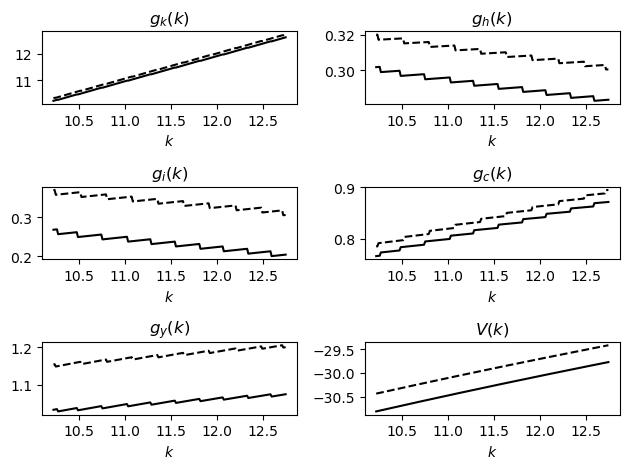

In [12]:
fig1, axs1 = plt.subplots(3, 2)

axs1[0,0].plot(SSK, gk[:,0], 'k-')
axs1[0,0].plot(SSK, gk[:,-1], 'k--')
axs1[0,0].set(xlabel='$k$', title='$g_{k}(k)$')

axs1[0,1].plot(SSK, gh[:,0], 'k-')
axs1[0,1].plot(SSK, gh[:,-1], 'k--')
axs1[0,1].set(xlabel='$k$', title='$g_{h}(k)$')

axs1[1,0].plot(SSK, gi[:,0], 'k-')
axs1[1,0].plot(SSK, gi[:,-1], 'k--')
axs1[1,0].set(xlabel='$k$', title='$g_{i}(k)$')

axs1[1,1].plot(SSK, gc[:,0], 'k-')
axs1[1,1].plot(SSK, gc[:,-1], 'k--')
axs1[1,1].set(xlabel='$k$', title='$g_{c}(k)$')

axs1[2,0].plot(SSK, gy[:,0], 'k-')
axs1[2,0].plot(SSK, gy[:,-1], 'k--')
axs1[2,0].set(xlabel='$k$', title='$g_{y}(k)$')

axs1[2,1].plot(SSK, v[:,0], 'k-')
axs1[2,1].plot(SSK, v[:,-1], 'k--')
axs1[2,1].set(xlabel='$k$', title='$V(k)$')

plt.tight_layout()
plt.savefig('Hansen_DDP_eff_policy_value.jpg', dpi=800)
plt.show()
plt.close(fig1)

In [13]:
#--------------------------------------------------------------------------
# Simulation for Hansen model with divisible labor
#--------------------------------------------------------------------------
#np.random.seed(1337)

ss = SSS
tm = TM
ns = ss.size

Igk = np.around((gk - SSK[0]) / (SSK[-1] - SSK[0]) * (nk - 1))-1

T = 115
N = 100

Ik = np.zeros((T,1),dtype=int)
Ik[0] = np.floor(SSK.size/2)-1   # Always start from kb (nearby).

ss_mat = np.zeros((N,6))
cc_mat = np.zeros((N,6))

for j in np.arange(0,N):
    Is = mcsim(ss,tm,T)
    
    for t in np.arange(1,T):
        Ik[t] = Igk[Ik[t-1],Is[t-1]]
    
    k = np.log(SSK[Ik.squeeze()])
    inv = np.log(gi[Ik,Is])
    c = np.log(gc[Ik,Is])
    h = np.log(gh[Ik,Is])
    y = np.log(gy[Ik,Is])
    prod = y - h  # productivity
    
    dhp, dtr = hp1(np.concatenate((y, inv, c, k, h, prod),axis=1), 1600)
    ss_mat[j,:] = np.std(dhp,axis=0,ddof=1)*100
    Corr = np.corrcoef(dhp,rowvar=False)
    cc_mat[j,:] = Corr[:,0]
    

std = np.mean(ss_mat,axis=0)
corr = np.mean(cc_mat,axis=0)

print('HANSEN: std(x)/std(y) corr(x,y) for y, i, c, k, h, prod')
print(np.concatenate((np.array([[1.36, 4.24, 0.42, 0.36, 0.7, 0.68]]).T/1.36, \
                  np.array([[1, 0.99, 0.89, 0.06, 0.98, 0.98]]).T),axis=1))
print('std(x) std(x)/std(y) corr(x,y) for y, i, c, k, h, prod:')
print(np.concatenate((std[:,np.newaxis], (std/std[0])[:,np.newaxis], corr[:,np.newaxis]),axis=1))

HANSEN: std(x)/std(y) corr(x,y) for y, i, c, k, h, prod
[[1.     1.    ]
 [3.1176 0.99  ]
 [0.3088 0.89  ]
 [0.2647 0.06  ]
 [0.5147 0.98  ]
 [0.5    0.98  ]]
std(x) std(x)/std(y) corr(x,y) for y, i, c, k, h, prod:
[[1.6382 1.     1.    ]
 [5.4338 3.3169 0.9816]
 [0.4833 0.295  0.6977]
 [0.4442 0.2711 0.0407]
 [0.9382 0.5727 0.966 ]
 [0.7702 0.4701 0.9491]]


In [14]:
#!jupyter nbconvert --to script Hansen_DDP_eff.ipynb